In [205]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
# pltのlabelで日本語を使うために必要なモジュールをインポート
import japanize_matplotlib
from matplotlib import rc
from matplotlib.font_manager import FontProperties
from scipy.stats import norm
from scipy.linalg import expm
from math import factorial


In [161]:
def linear_Z(A,theta1,t_max,dt,seed):
    np.random.seed(seed)
    # 時間パラメータ
    dt = dt/10 # 時間刻み
    N = int(t_max / dt)  # ステップ数

    # ブラウン運動のサンプルパスを生成
    dW = norm.rvs(scale=np.sqrt(dt), size=N)
    W = np.cumsum(dW)

    # 確率過程Z_tの計算
    Z_t = np.zeros((2, N+1))  # 結果を格納する配列
    integrand = np.zeros((2, N+1))  # 積分項を格納する配列

    for i in range(1, N+1):
        t = i * dt
        integrand[:, i] = expm(-A * t) @ np.array([theta1, 0]) * dW[i-1]
        Z_t[:, i] = expm(A * t) @ np.sum(integrand[:, :i+1], axis=1)

    return Z_t[:,::10]

In [162]:
A = np.array([[-1, -1], [1, 0]])
theta1 = 1
t_max = 10
dt = 0.001
seed = 0
N = int(t_max / dt)  # ステップ数

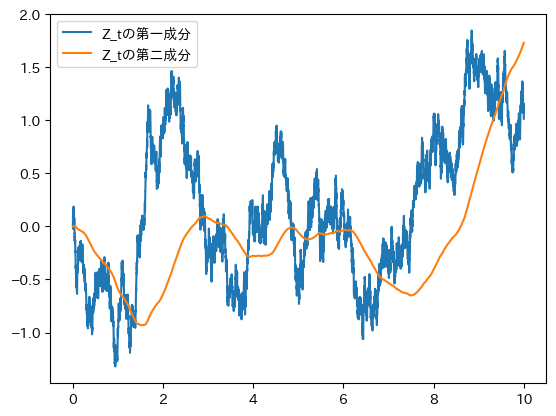

In [163]:
Z_t = linear_Z(A,theta1,t_max,dt,seed)
plt.plot(np.linspace(0, t_max, N+1), Z_t[0, :], label='Z_tの第一成分')
plt.plot(np.linspace(0, t_max, N+1), Z_t[1, :], label='Z_tの第二成分')
plt.legend()
plt.show()


In [215]:
def compute_s(theta1, theta21,theta22, theta3, k0):
    s = {}
    # aの計算
    a = {}
    a[0] = 1
    a[-1] = 0
    for k in range(1, k0+1):
        a[k] = -theta21 * a[k-1]  - theta22 *theta3 * a[k-2]
    
    # 各成分の計算
  
    for m in range(k0 + 1):
        mat11 = 0
        mat12 = 0
        mat22 = 0
        for k in range(min(m+1, k0)):
            l = m - k
            
            # 1,1成分の計算
            mat11 += theta1**2 * scipy.special.comb(m,k) *a[k] * a[l]/np.math.factorial(m+1) 
            
            # 1,2成分の計算
            mat12 += theta1**2 * theta3 * scipy.special.comb(m+1,k) *a[k] * a[l]/np.math.factorial(m+2)
            
            # 2,2成分の計算
            mat22 += theta3**2 * theta1**2 * scipy.special.comb(m+2,k+1) *a[k] * a[l]/np.math.factorial(m+3)
        s[m] = np.array([[mat11, mat12], [mat12, mat22]])
    return s

In [216]:
compute_s(1,1,1,1,3)

{0: array([[1.        , 0.5       ],
        [0.5       , 0.33333333]]),
 1: array([[-1.  , -0.5 ],
        [-0.5 , -0.25]]),
 2: array([[0.33333333, 0.125     ],
        [0.125     , 0.05      ]]),
 3: array([[0.04166667, 0.00833333],
        [0.00833333, 0.00694444]])}

In [195]:
np.linalg.inv(compute_s(1, 1, 1, 1, 3)[0])

array([[ 4., -6.],
       [-6., 12.]])

In [217]:
calculate_d_e(compute_s(1, 1, 1, 1, 3))

({0: array([[ 4., -6.],
         [-6., 12.]]),
  1: array([[-1.,  0.],
         [ 0.,  0.]]),
  2: array([[ 3.13333333, -1.1       ],
         [-1.1       ,  1.2       ]]),
  3: array([[-8.98333333,  0.7       ],
         [ 0.7       ,  1.3       ]])},
 {0: -2.4849066497880004,
  1: array([[1., 1.],
         [1., 1.]]),
  2: array([[-6.86666667, -6.86666667],
         [-6.86666667, -6.86666667]]),
  3: array([[39.55, 39.55],
         [39.55, 39.55]])})

In [212]:
import numpy as np
from math import factorial

def calculate_d_e(s):
    d = {k: np.zeros_like(s[0]) for k in s.keys()}
    e = {k: np.zeros_like(s[0]) for k in s.keys()}
    k0 = max(s.keys())
    d[0] = np.linalg.inv(s[0])
    for m in range(1, k0+1):
        for p in range(m):
            for q in range(m):
                if p + q > m-1:
                    continue
                else:
                    r = m - p - q - 1
                    d[m] += factorial(m-1)/(factorial(p)*factorial(q)*factorial(r)) * np.dot(np.dot(d[p], s[q+1]), d[r])
    e[0] = np.log(np.linalg.det(s[0]))
    for m in range(1, k0+1):
        for p in range(m):
            q = m - p -1
            e[m] += - factorial(m)/factorial(p) * np.trace(np.dot(d[p+1], s[q]))
    return d, e
